In [2]:
from pyspark.sql import SparkSession

#### Step 1: Creating a SparkSession

In [3]:
spark = SparkSession.builder.appName("PysparkApp").master("local[*]").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

#### Step 2: Creating the DataFrame

In [4]:
df = spark.read.csv('data/datacamp_ecommerce.csv',header=True,escape="\"")

In [5]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

In [6]:
df.count()

12500

In [7]:
df.columns

['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

1. InvoiceNo: The unique identifier of each customer invoice.
2. StockCode: The unique identifier of each item in stock.
3. Description: The item purchased by the customer.
4. Quantity: The number of each item purchased by a customer in a single invoice.
5. InvoiceDate: The purchase date.
6. UnitPrice: Price of one unit of each item.
7. CustomerID: Unique identifier assigned to each user.
8. Country: The country from where the purchase was made

#### Step 3: Exploratory Data Analysis

In [8]:
df.count()

12500

In [9]:
df.select("CustomerID").distinct().count()

373

In [10]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [11]:
df.groupBy("Country").agg(countDistinct('CustomerID').alias('country_count')).show()

+--------------+-------------+
|       Country|country_count|
+--------------+-------------+
|       Germany|           11|
|        France|            4|
|       Belgium|            1|
|         Italy|            2|
|          EIRE|            3|
|     Lithuania|            1|
|        Norway|            1|
|         Spain|            1|
|   Switzerland|            1|
|         Japan|            1|
|        Poland|            1|
|      Portugal|            2|
|     Australia|            1|
|United Kingdom|          343|
|   Netherlands|            1|
+--------------+-------------+



In [19]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+--------------+-------------+
|       Country|country_count|
+--------------+-------------+
|United Kingdom|          343|
|       Germany|           11|
|        France|            4|
|          EIRE|            3|
|         Italy|            2|
|      Portugal|            2|
|       Belgium|            1|
|     Lithuania|            1|
|        Norway|            1|
|         Spain|            1|
|   Switzerland|            1|
|         Japan|            1|
|        Poland|            1|
|     Australia|            1|
|   Netherlands|            1|
+--------------+-------------+



In [20]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date', to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-06-10 13:13:00|
+-------------------+



In [21]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2012-01-10 08:26:00|
+-------------------+



#### Step 4: Data Pre-processing

In [22]:
df.show(5, 0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEA

### Recency

##### i) Assign a recency score to each customer

In [23]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date', to_timestamp("from_date", 'yyyy/MM/dd HH:mm'))

df2 = df.withColumn('from_date', to_timestamp(col("from_date"))).withColumn('recency', col('date').cast("long") - col('from_date').cast("long"))

In [24]:
df2

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: string, InvoiceDate: string, UnitPrice: string, CustomerID: string, Country: string, date: timestamp, from_date: timestamp, recency: bigint]

##### ii) Select the most recent purchase

In [25]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')), on='recency',how='leftsemi')

In [26]:
df2.show(5,0)

+-----------+---------+---------+-------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency    |InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+-----------+---------+---------+-------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|63113903792|536369   |21756    |BATH BUILDING BLOCK WORD       |3       |12/1/10 8:35|5.95     |13047     |United Kingdom|2012-01-10 08:35:00|0012-01-10 08:26:00|
|63113904392|536370   |22728    |ALARM CLOCK BAKELIKE PINK      |24      |12/1/10 8:45|3.75     |12583     |France        |2012-01-10 08:45:00|0012-01-10 08:26:00|
|63113904392|536370   |22727    |ALARM CLOCK BAKELIKE RED       |24      |12/1/10 8:45|3.75     |12583     |France        |2012-01-10 08:45:00|0012-01-10 08:26:00|
|63113904392|536

In [27]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



### Frequency

In [28]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [29]:
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|16250     |14       |
|15574     |121      |
|15555     |32       |
|17757     |23       |
|13174     |169      |
+----------+---------+
only showing top 5 rows



In [30]:
df3 = df2.join(df_freq, on='CustomerID', how='inner')

In [31]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



#### Monetary Value

##### i) Find the total amount spent in each purchase:

In [32]:
df[["CustomerID","Quantity","UnitPrice"]].show()

+----------+--------+---------+
|CustomerID|Quantity|UnitPrice|
+----------+--------+---------+
|     17850|       6|     2.55|
|     17850|       6|     3.39|
|     17850|       8|     2.75|
|     17850|       6|     3.39|
|     17850|       6|     3.39|
|     17850|       2|     7.65|
|     17850|       6|     4.25|
|     17850|       6|     1.85|
|     17850|       6|     1.85|
|     13047|      32|     1.69|
|     13047|       6|      2.1|
|     13047|       6|      2.1|
|     13047|       8|     3.75|
|     13047|       6|     1.65|
|     13047|       6|     4.25|
|     13047|       3|     4.95|
|     13047|       2|     9.95|
|     13047|       3|     5.95|
|     13047|       3|     5.95|
|     13047|       4|     7.95|
+----------+--------+---------+
only showing top 20 rows



In [33]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [35]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [37]:
find_df = m_val.join(df3, on='CustomerID', how='inner')

In [38]:
find_df = find_df.select(['recency', 'frequency', 'monetary_value', 'CustomerID']).distinct()

In [41]:
find_df.show(5, 0)

+-----------+---------+------------------+----------+
|recency    |frequency|monetary_value    |CustomerID|
+-----------+---------+------------------+----------+
|63113908832|14       |226.14            |16250     |
|63116608052|121      |375.65            |15574     |
|63124376792|32       |198.43            |15555     |
|63116613512|23       |143.45            |17757     |
|63124382732|169      |1415.9700000000003|13174     |
+-----------+---------+------------------+----------+
only showing top 5 rows



### Standardization

In [42]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble = VectorAssembler(inputCols=[
    'recency', 'frequency', 'monetary_value'
], outputCol='features')

assembled_data=assemble.transform(find_df)

scale=StandardScaler(inputCol='features', outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [43]:
data_scale_output.select('standardized').show(2, truncate=False)

+---------------------------------------------------------+
|standardized                                             |
+---------------------------------------------------------+
|[13356.338433150926,0.565625077904778,0.5902534489538569]|
|[13356.909649488065,4.888616744748438,0.9804930932144527]|
+---------------------------------------------------------+
only showing top 2 rows



### Step 5: Building the Machine Learning Model

#### i) Finding the number of clusters to use

In [44]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator=ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2, 10):
    KMeans_algo = KMeans(featuresCol='standardized', k=i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

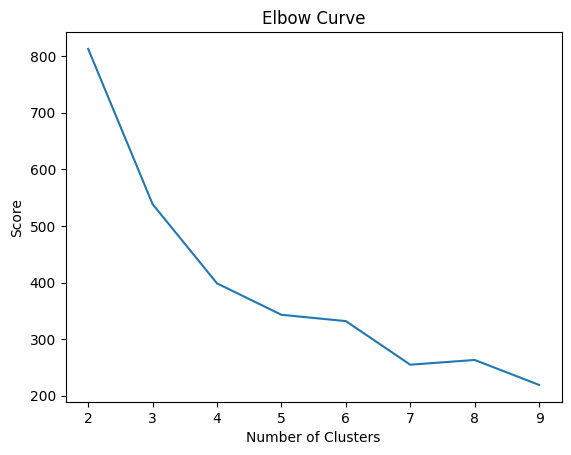

In [45]:
import pandas as pd
import matplotlib.pyplot as pl

df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

#### ii) Building the K-Means Clustering Model

In [46]:
KMeans_algo = KMeans(featuresCol='standardized', k=4)
KMeans_fit = KMeans_algo.fit(data_scale_output)

#### iii) Making Predictions

In [47]:
preds = KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+-----------+---------+------------------+----------+------------------------------------------+----------------------------------------------------------+----------+
|recency    |frequency|monetary_value    |CustomerID|features                                  |standardized                                              |prediction|
+-----------+---------+------------------+----------+------------------------------------------+----------------------------------------------------------+----------+
|63113908832|14       |226.14            |16250     |[6.3113908832E10,14.0,226.14]             |[13356.338433150926,0.565625077904778,0.5902534489538569] |3         |
|63116608052|121      |375.65            |15574     |[6.3116608052E10,121.0,375.65]            |[13356.909649488065,4.888616744748438,0.9804930932144527] |1         |
|63124376792|32       |198.43            |15555     |[6.3124376792E10,32.0,198.43]             |[13358.553691547246,1.2928573209252068,0.5179269119833458]|2         

### Step 6: Cluster Analysis

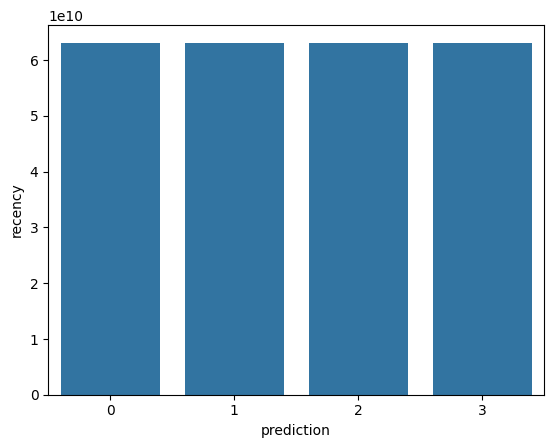

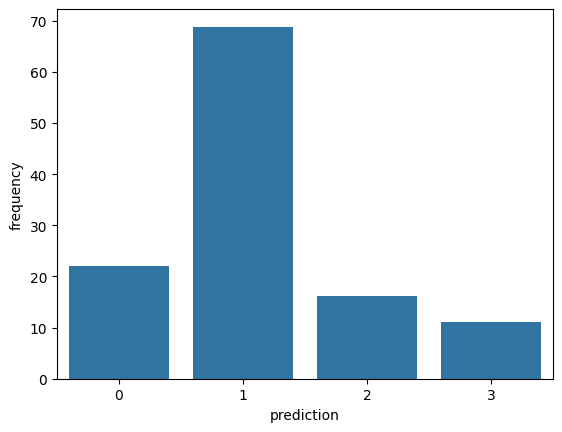

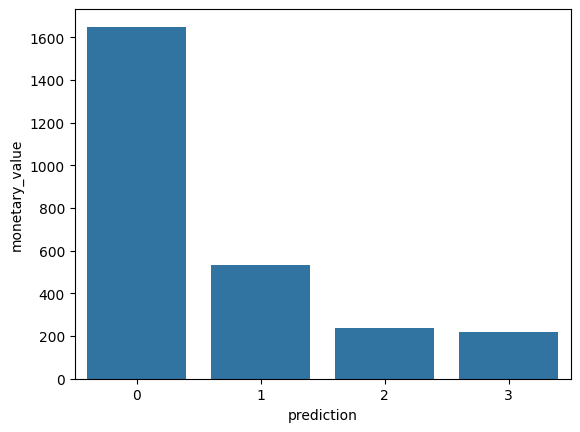

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency', 'frequency', 'monetary_value']

for i in list1:
    sns.barplot(x='prediction', y=str(i), data=avg_df)
    plt.show()